In [1]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torchvision.utils import make_grid
from torch.utils.data import random_split
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import models, transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
import cv2
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [2]:
def crop(image, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels (assumes that the input's size and the new size are
    even numbers).
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    middle_height = image.shape[2] // 2
    middle_width = image.shape[3] // 2
    starting_height = middle_height - new_shape[2] // 2
    final_height = starting_height + new_shape[2]
    starting_width = middle_width - new_shape[3] // 2
    final_width = starting_width + new_shape[3]
    cropped_image = image[:, :, starting_height:final_height, starting_width:final_width]
    return cropped_image

class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(input_channels * 2, input_channels * 2, kernel_size=3, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels * 2)
        self.use_bn = use_bn
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class:
    Performs an upsampling, a convolution, a concatenation of its two inputs,
    followed by two more convolutions with optional dropout
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=2)
        self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(input_channels // 2, input_channels // 2, kernel_size=2, padding=1)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
        '''
        x = self.upsample(x)
        x = self.conv1(x)
        skip_con_x = crop(skip_con_x, x.shape)
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv3(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x

class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a U-Net - 
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

class UNet(nn.Module):
    '''
    UNet Class
    A series of 4 contracting blocks followed by 4 expanding blocks to 
    transform an input image into the corresponding paired image, with an upfeature
    layer at the start and a downfeature layer at the end.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=32):
        super(UNet, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_dropout=True)
        self.contract2 = ContractingBlock(hidden_channels * 2, use_dropout=True)
        self.contract3 = ContractingBlock(hidden_channels * 4, use_dropout=True)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.contract5 = ContractingBlock(hidden_channels * 16)
        self.contract6 = ContractingBlock(hidden_channels * 32)
        self.expand0 = ExpandingBlock(hidden_channels * 64)
        self.expand1 = ExpandingBlock(hidden_channels * 32)
        self.expand2 = ExpandingBlock(hidden_channels * 16)
        self.expand3 = ExpandingBlock(hidden_channels * 8)
        self.expand4 = ExpandingBlock(hidden_channels * 4)
        self.expand5 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        '''
        Function for completing a forward pass of UNet: 
        Given an image tensor, passes it through U-Net and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        x5 = self.contract5(x4)
        x6 = self.contract6(x5)
        x7 = self.expand0(x6, x5)
        x8 = self.expand1(x7, x4)
        x9 = self.expand2(x8, x3)
        x10 = self.expand3(x9, x2)
        x11 = self.expand4(x10, x1)
        x12 = self.expand5(x11, x0)
        xn = self.downfeature(x12)
        return xn

In [3]:
# # Building Discriminator

class Discriminator(nn.Module):
    def __init__(self, in_channels=3,):
        super(Discriminator, self).__init__()

        
        self.model = nn.Sequential(
                     nn.Conv2d(6, 64, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.Conv2d(64, 128, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.Conv2d(128, 256, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.Conv2d(256, 512, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.ZeroPad2d((1, 0, 1, 0)),
                     nn.Conv2d(512, 1, 4, padding=1, bias=False)
                     
                     )

        
    def forward(self, img_A, img_B):
        # Here we are concatenating the images on their channels
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)


In [7]:
#My UNET Implementation
class conv_block(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(conv_block,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,1,1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            # nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,3,1,1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
            # nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.model(x)
class conv_transpose_block(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(conv_transpose_block, self).__init__()
        
        self.model = nn.Sequential( 
                         nn.ConvTranspose2d(in_channels, out_channels, 2, 2, bias=False),
                         nn.InstanceNorm2d(out_channels),
                         nn.ReLU(inplace=True),
                    )

    def forward(self, x, skip_input,i):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x

class UNET(nn.Module):
    def __init__(self,in_channels=3,out_channels=3):
        super(UNET,self).__init__()
        self.pool = nn.MaxPool2d(2,2)
        self.c1 = conv_block(in_channels,64)
        self.c2 = conv_block(64,128)
        self.c3 = conv_block(128,256)
        self.c4 = conv_block(256,512)
        self.c5 = conv_block(512,1024)
        self.ct1 = conv_transpose_block(1024,512)
        self.c6 = conv_block(1024,512)
        self.ct2 = conv_transpose_block(512,256)
        self.c7 = conv_block(512,256)
        self.ct3 = conv_transpose_block(256,128)
        self.c8 = conv_block(256,128)
        self.ct4 = conv_transpose_block(128,64)
        self.c9 = conv_block(128,64)
        self.final = nn.Conv2d(64,out_channels,1)
            
    def forward(self,x):
        l1 = self.c1(x) # channels:64
        l2 = self.pool(l1)# size:256
        l3 = self.c2(l2)# channels:128
        l4 = self.pool(l3)# size:128 
        l5 = self.c3(l4)# channels:256
        l6 = self.pool(l5)# size:64
        l7 = self.c4(l6)# channels:512
        l8 = self.pool(l7)# size:32
        l9 = self.c5(l8)# channels:1024 
        l10 = self.ct1(l9,l7,1)# size:64 
        l11 = self.c6(l10)# channels:512
        l12 = self.ct2(l11,l5,2)# size:128
        l13 = self.c7(l12)# channels:256
        l14 = self.ct3(l13,l3,3)# size:256
        l15 = self.c8(l14)# channels:128
        l16 = self.ct4(l15,l1,4)# size:512
        l17 = self.c9(l16)# channels:64
        l18 = self.final(l17)# size:512 channels:3
        return l18

In [4]:

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
FILE = "comic_generator.pth"
generator = UNet(3,3)
generator.load_state_dict(torch.load(FILE))
generator = generator.to('cuda')

In [5]:

def print_images(image_tensor, num_images):
    print('reached')
    images = image_tensor.detach().cpu()
    image_grid = make_grid(images[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [6]:
def save_predictions_as_imgs(
    loader, model, folder="saved_image", device="cuda"
):
    # model.eval()
    print("Saving Images =>")
    idx = 0
    for image, _ in loader:
        image_width = image.shape[3]
        target = image[:, :, :, :image_width // 2].to(device)
        real = image[:, :, :, image_width // 2:].to(device)

        with torch.no_grad():
            preds = model(real)
            # preds = DeNormalize(preds)
            # preds = (preds > 0.5).float()
        if idx % 100 == 0:
            torchvision.utils.save_image(
                preds, f"{folder}/pred_{idx}.png"
            )
            torchvision.utils.save_image(
                target.squeeze(), f"{folder}/target_{idx}.png")
        idx += 1
        break

    model.train()

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=174x208 at 0x233F97E6388>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


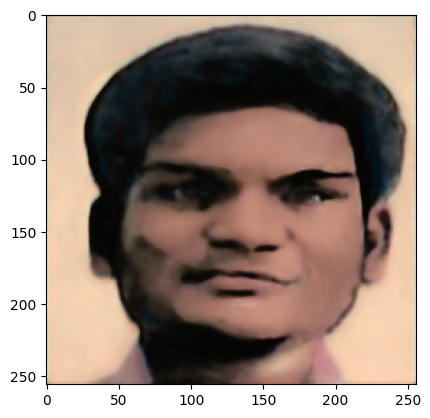

In [16]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()
from PIL import Image 
img = Image.open(r"C:\Users\Aman Sheikh\Pictures\Aman_3.jpg")
print(img)
from torchvision import models, transforms, datasets
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
generator = generator.to('cuda')
img = data_transform(img).to('cuda')
img = torch.unsqueeze(img,0)
output = generator(img)
# print(out)
# output = output.to('cuda')
show_tensor_images(output,size=(3, 256, 256))

  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([1, 3, 256, 256])
reached


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


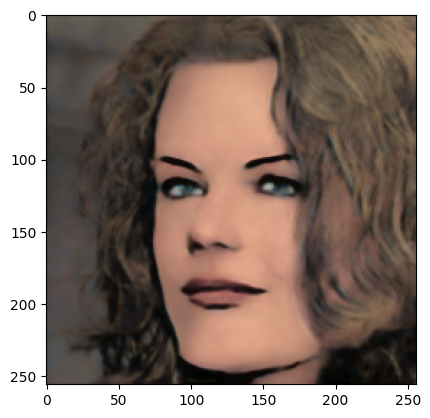

reached


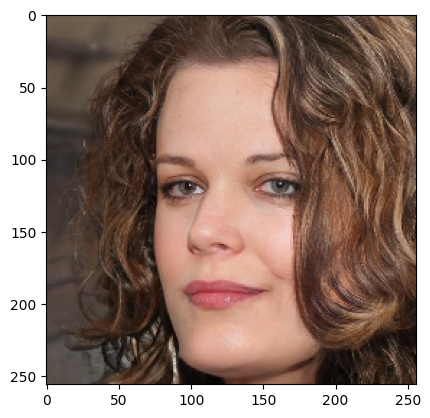

In [11]:
import cv2
from PIL import Image 
DATADIR = r"D:\dataset\face2comics_v1.0.0_by_Sxela\face2comics_v1.0.0_by_Sxela\combined"
data_transform = transforms.Compose([
    transforms.ToTensor(),
])
dataset = torchvision.datasets.ImageFolder(DATADIR, transform=data_transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
for image, _ in tqdm(dataloader):
    image_width = image.shape[3]
    target = image[:, :, :, :image_width // 2]
    target = nn.functional.interpolate(target, size=256)
    real = image[:, :, :, image_width // 2:]
    real = nn.functional.interpolate(real, size=256)
    cur_batch_size = len(target)
    target = target.to('cuda')
    real = real.to('cuda')
    output = generator(real)
    print(output.shape)
    print_images(output,5)
    print_images(real,5)
    torchvision.utils.save_image(
                output, f"o.png"
            )
    torchvision.utils.save_image(
                real, f"o1.png"
            )
    break


In [55]:
# torch.save(gen,'final_generator.pt')
gene = UNet(3,3)
gene = torch.load('final_generator.pt')
# dont use eval after loading a model

In [5]:
gen = UNet(3,3)
loaded_state = torch.load("D:\ganModels\pix2pix_3400.pth")
gen.load_state_dict(loaded_state["gen"])

<All keys matched successfully>